In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
from scipy import stats
import pandas as pd

In [3]:
import datetime as dt

In [4]:
from IPython.display import display

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys() 

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)


# Exploratory Climate Analysis

('2017-08-23')

C:\Users\etass\anaconda3\envs\class_31\lib\site-packages\pandas\plotting\_matplotlib\core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


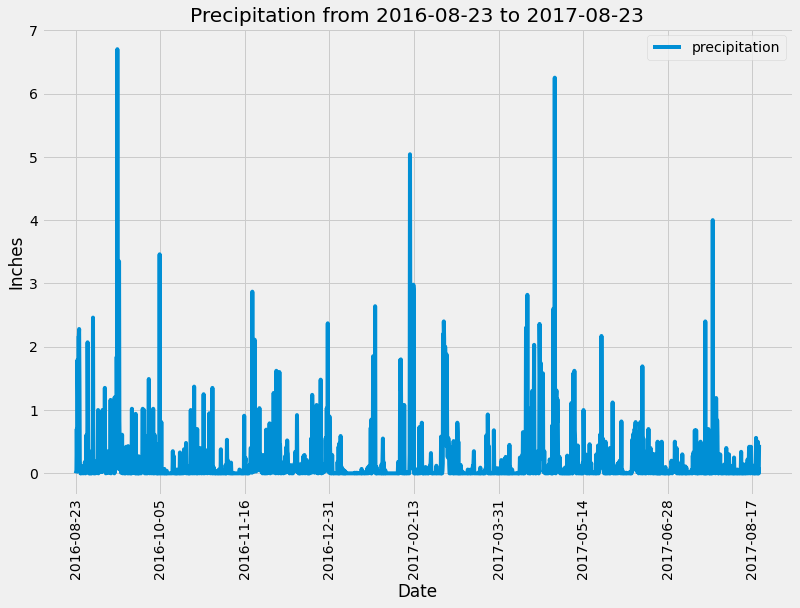

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
# Last date in dataset is 2017-8-23 so one year prior will be 2016-08-23
# Need dates in this range
# Latest Date found with this query or by examining data e.g. using DB Browser
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

# Display last date of dataset
display(last_date)

# Set the start and end dates required
# Set start date one day earlier to capture 2016-08-23
# date_start = dt.datetime(2016,8,22)
# date_end = dt.datetime(2017, 8, 23)

# Convert date from query above to required datetime object
date_time_obj = dt.datetime.strptime(last_date[0],"%Y-%m-%d")

# Extract date from datetime object
date_end = date_time_obj.date()

# Calculate one year before from end date
date_start = date_end - dt.timedelta(days=365)

# Perform a query to retrieve the date and precipitation values
results = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= date_start).filter(Measurement.date <= date_end).all()

"""for result in results:
    (measurement_date, measurement_prcp) = result
    print(f"{measurement_date}  {measurement_prcp}")"""
    
# Save the query results as a Pandas DataFrame and set the index to the date column
date_prcp_df = pd.DataFrame(results)

# Drop any data points with NaN for precipitation as cannot be sure what has happened there
# Note that NaN (or NULL) is distinct from a precipitation of 0.0 which is recorded properly
date_prcp_df_clean = date_prcp_df.dropna()

# Set the index of the DataFrame to the date
date_prcp_df_clean.set_index("date", inplace=True)

# Sort the dataframe by date
date_prcp_df_clean_sort = date_prcp_df_clean.sort_index()

# Rename column prcp to precipitation for better display in plot
date_prcp_df_clean_sort.rename(columns = {"prcp" : "precipitation"}, inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
ax = date_prcp_df_clean_sort.plot(figsize=(12,8), rot=90, title="Precipitation from 2016-08-23 to 2017-08-23", xlabel="Date", ylabel="Inches");

# Produces warning -- from Google searching seems to be a bug in matplotlib currently
# Does not affect plot

# Save figure as PNG file
plt.savefig("Precipitation in Last Year.png", bbox_inches = "tight")

In [12]:
# Use Pandas to calculate the summary statistics for the precipitation data
date_prcp_df_clean_sort.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [13]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(Station).count()

# Print out result of query
print(f"There are {station_count} stations in the dataset.")

There are 9 stations in the dataset.


In [14]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

# Query counts how many times each station's name appears and sorts in descending order
station_activity = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

# Display station_activity with row counts in descending order
display(station_activity)


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [15]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

# Station ID with most activity is USC00519281 with 2772 observations
# At location [0][0] in station_activity
most_active_station_temps = session.query(Measurement.station, func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).filter(Measurement.station == station_activity[0][0]).all()

# Display results 
# display(most_active_station_temps)

# Print out results nicely
print(f"Most active station is {most_active_station_temps[0][0]}")
print("----------------------------------------------------------")
print(f"Lowest temperature = {most_active_station_temps[0][1]}F")
print(f"Highest temperature = {most_active_station_temps[0][2]}F")
print(f"Average temperature = {most_active_station_temps[0][3]}F")

Most active station is USC00519281
----------------------------------------------------------
Lowest temperature = 54.0F
Highest temperature = 85.0F
Average temperature = 71.66378066378067F


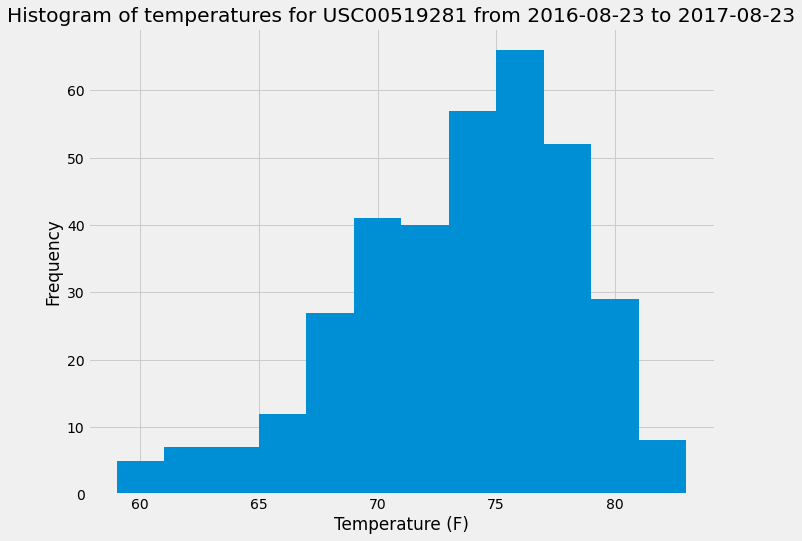

In [16]:
# Choose the station with the highest number of temperature observations

# Found this in previous section to be USC00519281 with 2772 observations
# At location [0][0] in station_activity

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
# Using dates from previous section 2016-08-23 to 2017-08-23
most_active_station_temps = session.query(Measurement.tobs).filter(Measurement.station == station_activity[0][0]).filter(Measurement.date > date_start).filter(Measurement.date <= date_end).all()

# Save temperatures into list from results using list comprehension
temperatures = [temp[0] for temp in most_active_station_temps[::]]

# Set up plot
fig, ax = plt.subplots(figsize=(10,8))

# Plot histogram with specified number of bins
plt.hist(temperatures, bins=12);

# Set x and y axis labels and plot title
ax.set_xlabel("Temperature (F)")
ax.set_ylabel("Frequency")
ax.set_title("Histogram of temperatures for USC00519281 from 2016-08-23 to 2017-08-23");

# Save figure as PNG file
plt.savefig("Histogram of Temperatures.png", bbox_inches = "tight")

## Bonus Challenge Assignment

### Temperature Analysis I

In [17]:
# Location of CSV data files
measurements_path = "Resources/hawaii_measurements.csv"
stations_path = "Resources/hawaii_stations.csv"

# Read the mouse data and the study results
hawaii_measurements = pd.read_csv(measurements_path)
hawaii_stations = pd.read_csv(stations_path)

# Display a preview of the DataFrames
display(hawaii_stations)
display(hawaii_measurements.head(10))

# Identify the average temperature in June at all stations across all available years in the dataset

# Convert date column to datatime 
hawaii_measurements["date"] = pd.to_datetime(hawaii_measurements["date"])

# Extract all the tobs i.e. temperatures across all years for June
june_tobs = hawaii_measurements[hawaii_measurements["date"].dt.month == 6]["tobs"]

# Place the June temperatures into a DataFrame
june_tobs_df = pd.DataFrame(june_tobs)

# Convert DataFrame to list of temperatures in June
june_tobs_list = june_tobs_df["tobs"].tolist()

# Calculate average of June temperatures
avg_june_tobs = june_tobs_df.mean()

# Extract all the tobs i.e. temperatures across all years for December
december_tobs = hawaii_measurements[hawaii_measurements["date"].dt.month == 12]["tobs"]

# Place the June temperatures into a DataFrame
december_tobs_df = pd.DataFrame(december_tobs)

# Convert DataFrame to list of temperatures in December
december_tobs_list = december_tobs_df["tobs"].tolist()

# Calculate average of December temperatures
avg_december_tobs = december_tobs_df.mean()

# Display average temperatures for June and December
print(f"Average June temperature = {avg_june_tobs[0]}F")
print(f"Average December temperature = {avg_december_tobs[0]}F")

# Unpaired (independent) t-test
# Using unpaired as comparing means of different groups
# Null hypothesis is that means of June and December are the same
stats.ttest_ind(june_tobs_list, december_tobs_list)


,station,name,latitude,longitude,elevation
0,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
1,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
2,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
3,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9
4,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6
5,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
6,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
7,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9
8,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4


,station,date,prcp,tobs
0,USC00519397,2010-01-01,0.08,65
1,USC00519397,2010-01-02,0.00,63
2,USC00519397,2010-01-03,0.00,74
3,USC00519397,2010-01-04,0.00,76
4,USC00519397,2010-01-06,NaN,73
5,USC00519397,2010-01-07,0.06,70
6,USC00519397,2010-01-08,0.00,64
7,USC00519397,2010-01-09,0.00,68
8,USC00519397,2010-01-10,0.00,73
9,USC00519397,2010-01-11,0.01,64


Average June temperature = 74.94411764705882F
Average December temperature = 71.04152933421226F


Ttest_indResult(statistic=31.60372399000329, pvalue=3.9025129038616655e-191)

The p-value for the t-test is very small, so the null hypothesis can be rejected.  The difference in average temperatures for June and December is statistically significant.

### Temperature Analysis II

In [18]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [19]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

# Trip dates are from July 21 to July 30
# Birthday is July 27, may as well try Hawaii! 

# Calculate tmin, tavg, tmax using given function
tobs_trip_dates = calc_temps('2017-07-21', '2017-07-30')

# Place values in separate variables
tmin = tobs_trip_dates[0][0]
tavg = tobs_trip_dates[0][1]
tmax = tobs_trip_dates[0][2]

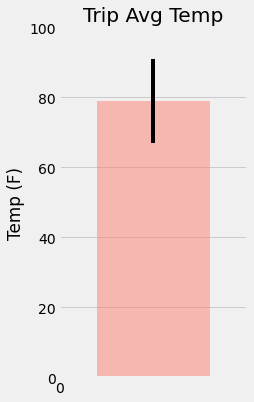

In [20]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

# Create plot
fig, ax = plt.subplots(figsize=(3,6))

# Calculate peak-to-peak value for y error bar
ptp = tmax - tmin

# Set x and y limits for plot
# y limit set to 100 to cater for error bar
ax.set_xlim(0,2)
ax.set_ylim(0,100)

# Only one bar to represent, so xticks can be set to just 0
ax.set_xticks([0])

# Plot bar chart
# Set bar at x=1, height at tavg, suitable width, color, alignment and transparency
# Trial and error to resemble plot in instructions
ax.bar(x=1, height=tavg, width=1.2, yerr=ptp, align='center', color='salmon', alpha=0.5)

# Set title for plot
ax.set_title("Trip Avg Temp")

# Set y label for plot
ax.set_ylabel("Temp (F)");

# Save figure as PNG file
plt.savefig("Trip Average Temperature.png", bbox_inches = "tight")

In [21]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

# Trip dates are from July 21 to July 30
# Birthday is July 27, may as well try Hawaii! 

# Construct query to retrieve data
# Join on station for required dates
# Group by station and order by sum of precipitation for each station
rainfall_per_station = session.query(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp)).\
                join(Station, Station.station == Measurement.station).\
                group_by(Measurement.station).\
                filter(Measurement.date >= '2017-07-21').filter(Measurement.date <= '2017-07.30').\
                order_by(func.sum(Measurement.prcp).desc()).all()

display(rainfall_per_station)

# Easier to display and read as a DataFrame
rainfall_per_station_df = pd.DataFrame(rainfall_per_station, columns=["Station", "Station Name", "Latitude", "Longitude", "Elevation", "Total Rainfall"])
display(rainfall_per_station_df)

[('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  7.339999999999999),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  1.6800000000000002),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  1.6),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.99),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.08),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  0.05),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.01)]

,Station,Station Name,Latitude,Longitude,Elevation,Total Rainfall
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,7.34
1,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,1.68
2,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,1.60
3,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,0.99
4,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.08
5,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.05
6,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,0.01


In [22]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [26]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
trip_start_date = "2018-07-21"
trip_end_date = "2018-07-30"

# Convert trip to datetime objects
date_time_start = dt.datetime.strptime(trip_start_date,"%Y-%m-%d")
date_time_end = dt.datetime.strptime(trip_end_date,"%Y-%m-%d")

# Use the start and end date to create a range of dates
dt_start_day= 21
dt_end_day = 30
dt_year = 2018
dt_month = 7

# Create empty list of trip dates
dt_date_range = []

# Loop over range of trip dates appending each new date to list
# Variable i keeps track of current day
for i in range(dt_start_day, dt_end_day+1):
    dt_current_day = []
    dt_current_day = dt.datetime(dt_year, dt_month, i)
    dt_date_range.append(dt_current_day)

# Trip dates list above had timestamps
# Create new list with timestamps removed and just containing YYYY-mm-dd dates
dt_trip_dates = []
for j in range(len(dt_date_range)):
    dt_trip_dates.append(dt_date_range[j].date())

# Display list of trip dates to check validity
display(dt_trip_dates)

# Initialise list of mm-dd strings to empty list
month_day_list = []

# Strip off the year and save a list of %m-%d strings
for k in range(len(dt_trip_dates)):
    
    # Place month and day into variables
    month = dt_trip_dates[k].strftime("%m")
    day = dt_trip_dates[k].strftime("%d")
    
    # Create string of form mm-dd
    month_day = f"{month}-{day}"
    
    # Append the string to list of strings
    month_day_list.append(month_day)
    
# Print list of strings to check for validity
print(f"{month_day_list}\n")

# Initialise normals list to empty list
daily_normals_list = []

# Loop through the list of %m-%d strings and calculate the normals for each date
for a in range(len(month_day_list)):
    
    # Store current calculated normal
    current_normal = daily_normals(month_day_list[a])
    
    # Append current normal to normals list
    daily_normals_list.append(current_normal[0])
    
# Display normals list
display(daily_normals_list)

[datetime.date(2018, 7, 21),
 datetime.date(2018, 7, 22),
 datetime.date(2018, 7, 23),
 datetime.date(2018, 7, 24),
 datetime.date(2018, 7, 25),
 datetime.date(2018, 7, 26),
 datetime.date(2018, 7, 27),
 datetime.date(2018, 7, 28),
 datetime.date(2018, 7, 29),
 datetime.date(2018, 7, 30)]

['07-21', '07-22', '07-23', '07-24', '07-25', '07-26', '07-27', '07-28', '07-29', '07-30']



[(69.0, 76.9245283018868, 83.0),
 (69.0, 75.78846153846153, 81.0),
 (70.0, 76.20370370370371, 84.0),
 (69.0, 76.55555555555556, 81.0),
 (67.0, 76.89090909090909, 84.0),
 (71.0, 76.4423076923077, 86.0),
 (68.0, 76.58181818181818, 83.0),
 (69.0, 76.46428571428571, 82.0),
 (69.0, 76.47058823529412, 83.0),
 (69.0, 77.35185185185185, 84.0)]

In [24]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
# Name calumns and set index to previously calculated list of trip dates
daily_normals_df = pd.DataFrame(daily_normals_list, columns=["tmin", "tavg", "tmax"], index = dt_trip_dates)
display(daily_normals_df)


,tmin,tavg,tmax
2018-07-21,69.0,76.924528,83.0
2018-07-22,69.0,75.788462,81.0
2018-07-23,70.0,76.203704,84.0
2018-07-24,69.0,76.555556,81.0
2018-07-25,67.0,76.890909,84.0
2018-07-26,71.0,76.442308,86.0
2018-07-27,68.0,76.581818,83.0
2018-07-28,69.0,76.464286,82.0
2018-07-29,69.0,76.470588,83.0
2018-07-30,69.0,77.351852,84.0


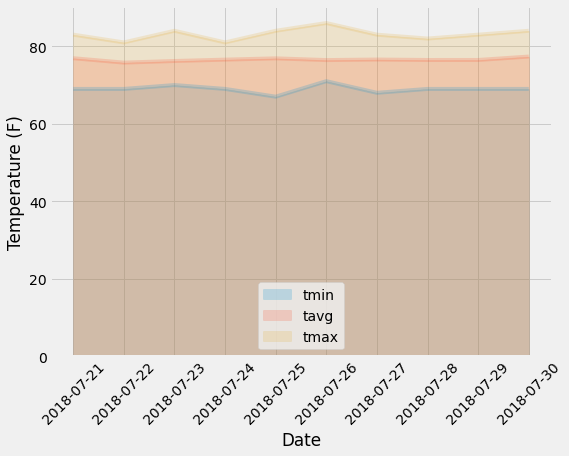

In [25]:
# Plot the daily normals as an area plot with `stacked=False`
ax1 = daily_normals_df.plot(kind="area", figsize=(8,6), rot=45, stacked=False, xlabel="Date", ylabel="Temperature (F)", alpha=0.2); 

# Had to move legend to lower center as it kept going off the side of the plot with lower left placement
ax1.legend(loc="lower center");

# Save figure as PNG file
plt.savefig("Daily Normals for Trip.png", bbox_inches = "tight")